> # A Song of Network and Natural Language Processing

# 0. Install and Import Libraries

install pip packages beautifulsoup4 in the current Jupyter kernel

In [1]:
import sys
!{sys.executable} -m pip install beautifulsoup4

import relevant libraries

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import math
import requests
import urllib.request
from bs4 import BeautifulSoup
import bleach
import re
import matplotlib.pyplot as plt
%matplotlib inline
from fa2 import ForceAtlas2
import pickle
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from community import community_louvain
import json
import pprint
from nltk.tokenize import word_tokenize
import wordcloud

define functions `printList` and `printDic` to print the first five elements in a list/dictionary.

In [3]:
def printList(lst):
    count = 0
    for i in lst:
        print(i)
        count += 1
        if count == 5:
            break
    return 

def printDic(dic):
    count = 0
    for (k,v) in dic.items():
        print(k , v)
        count += 1
        if count == 5:
            break
    return

# 1. Data Extraction

In this section, we obtain data related to Game of Thrones from various sources.

## 1.1. Obtain Character Names and GOT Wiki Pages
This section involves two steps:
1. There are two tables listing main characters in the [Wikipedia page](https://en.wikipedia.org/wiki/List_of_Game_of_Thrones_characters). First, we read in the table and extract the character names. 

2. For each name obtained in step 1, scrape the Game of Thrones Wiki site to find the corresponding page of this character.

In [4]:
table1=pd.read_csv("table-1.csv")
table2=pd.read_csv("table-2.csv")

In [5]:
# table1 stores the main characters in the GOT series
table1.head()

Actor/Actress         Character Appearances Appearances.1  \
0          Actor/Actress         Character           1             2   
1           Sean Bean[a]      Eddard Stark        Main           NaN   
2              Mark Addy  Robert Baratheon        Main           NaN   
3  Nikolaj Coster-Waldau   Jaime Lannister        Main          Main   
4       Michelle Fairley     Catelyn Stark        Main          Main   

  Appearances.2 Appearances.3 Appearances.4 Appearances.5 Appearances.6  \
0             3             4             5             6             7   
1           NaN           NaN           NaN     Recurring         Guest   
2           NaN           NaN           NaN           NaN           NaN   
3          Main          Main          Main          Main          Main   
4          Main           NaN           NaN           NaN           NaN   

  Appearances.7  
0             8  
1           NaN  
2           NaN  
3          Main  
4           NaN

In [6]:
# table2 stores the recurring characters in the GOT series
table2.head()

Actor/Actress              Character Appearances Appearances.1  \
0      Actor/Actress              Character           1             2   
1      Julian Glover  Grand Maester Pycelle   Recurring     Recurring   
2        Ian Beattie            Meryn Trant   Recurring     Recurring   
3  Kristian Nairn[a]                  Hodor   Recurring     Recurring   
4       Mark Stanley                  Grenn   Recurring     Recurring   

  Appearances.2 Appearances.3 Appearances.4 Appearances.5 Appearances.6  \
0             3             4             5             6             7   
1     Recurring     Recurring     Recurring     Recurring           NaN   
2     Recurring     Recurring     Recurring           NaN           NaN   
3     Recurring     Recurring           NaN     Recurring           NaN   
4     Recurring     Recurring           NaN           NaN           NaN   

  Appearances.7  
0             8  
1           NaN  
2           NaN  
3           NaN  
4           NaN

In [7]:
# obtain the main characters and recurring characters lists
# join the two lists
list1=table1.Character.tolist()[1:]
list2=table2.Character.tolist()[1:]
list_full=list1 + list2

# print the first five elements in the list
printList(list_full)

Eddard Stark
Robert Baratheon
Jaime Lannister
Catelyn Stark
Cersei Lannister


We then use web scraping (with the help of `BeautifulSoup` library) to extract each character's information from the Game of Thrones Wiki

In [8]:
# define a funciton to extract the GOT Wiki page content of a character.

def getText():
    
    pages_dic={}
    
    for character in list_full:
    
        # parse url character name
        if " " in character:
            character = re.sub(r" ", "_", character)

        url="https://gameofthrones.fandom.com/wiki/" + character # get base url

        response = requests.get(url) # request a server response

        # not found
        if response.status_code == 404:
            print("{} wiki is not found.".format(character))
            continue

        soup = BeautifulSoup(response.text, "html.parser") # parse text from html

        para=soup.findAll('p') # find all paragraphs

        # clean the raw text
        res=[]
        for p in para:
            p = re.sub(r"<.+?>", "", str(p)) # remove all other tags e.g. <a href>
            p = re.sub(r"\[\d+?\]", " ", p)  # remove footnote label e.g. [1], [2]
            p = re.sub(r"\n", "", p)         # remove newline character
            p = re.sub(r"\xa0", u" ", p)     # remove empty space due to encoding

            if len(p) != 0 and p[-1] == " ": # remove empty space at the end, if present
                p = p[:-1]
            res.append(p)

        page = "".join(res)
        
        # store the character and his/her corresponding page to a dictionary
        pages_dic[character] = page
    
    # save the file as a pickle object
    pickle.dump(pages_dic, open('pages.p', 'wb'))
    
    return None

In [9]:
# only run once
# getText()

In [10]:
# load the pickled file
infile = open("pages.p",'rb')
pages = pickle.load(infile)
infile.close()

## 1.2. Obtain a Dictionary Storing Character Names and Their Variants
There are mismatches between the Wikipedia character names and the names used in GOT Wiki, as it is not uncommon for a character to have nicknames/aliases. We need to resolve this so as to build a more representative network. 
<br>
<br>
To achieve this, we search the Web and collect a list of all possible nicknames/aliases for each character. It is a slow and tedious process, but we cannot find a better workaround at this point. We then build a dictionary with key being a character's full name and value being his/her list of nicknames. 
<br>
<br>
Note that we will only consider nicknames of characters who are mentioned in [GOT Wiki](https://gameofthrones.fandom.com/wiki/Game_of_Thrones_Wiki).

In [11]:
# define a function to create a dictionary of aliases, as described above
def characterDic():
    
    nicknames = {}
    
    for name in pages.keys():
        parsed_name = name.replace("_", " ")
        nicknames[parsed_name] = [parsed_name,]
    
        # special cases --> not really literal names     
        if parsed_name in ["High Septon", "Black Walder Rivers", "Spice King",
                           "Night King", "Wun Weg Wun Dar Wun", "Lady Crane",
                           "Grey Worm", "Silk King","Little Sam","Hot Pie",
                           "Khal Drogo","Three-Eyed Raven","Black Lorren",
                           "Maester Luwin", "Maester Aemon","The Waif"]:
            continue
                  
        # general case --> extract the first name
        if " " in parsed_name:
            firstname = parsed_name.split(" ")[0]
            nicknames[parsed_name] += [firstname,]
    
    # Some manual editing to improve accuracy
    nicknames["Jon Snow"] += ["Aegon", "Lord Snow"]
    nicknames["Bran Stark"] += ["Three-Eyed Raven", "Brandon"]
    nicknames["Davos Seaworth"] += ["Onion Knight", "Davos"]
    nicknames["Jaime Lannister"] += ["Kingslayer"]
    nicknames["Tyrion Lannister"] += ["Imp", "Halfman", "Little Lion"]
    nicknames["Gregor Clegane"] += ["The Mountain",]
    nicknames["Joffrey Baratheon"] += ["Joff"]
    nicknames["Daenerys Targaryen"] += ["Daenerys Stormborn", "Stormborn", "Dany", 
                                       "Mhysa", "Dragon Queen", "Khaleesi"]
    nicknames["Varys"] += ["Spider", "Eunuch"]
    nicknames["Theon Greyjoy"] += ["Reek",]
    nicknames["Grey Worm"] += ["Torgo Nudho",]
    nicknames["Olenna Tyrell"] += ["Redwyne",]
    nicknames["Brienne of Tarth"] += ["Brienne", "Maid of Tarth"]
    nicknames["Samwell Tarly"] += ["Sam", "Piggy"]
    nicknames["Gendry Baratheon"] = ["Gendry", "Clovis"]
    nicknames["Petyr Baelish"] += ["Littlefinger", "Baelish"]
    nicknames["Sandor Clegane"] += ["Hound"]
    nicknames["Melisandre"] += ["Red Woman", "Red Witch"]
    
    return nicknames

In [12]:
characters = characterDic()
printDic(characters)

Eddard Stark ['Eddard Stark', 'Eddard']
Robert Baratheon ['Robert Baratheon', 'Robert']
Jaime Lannister ['Jaime Lannister', 'Jaime', 'Kingslayer']
Catelyn Stark ['Catelyn Stark', 'Catelyn']
Cersei Lannister ['Cersei Lannister', 'Cersei']


## 1.3. Find Important Wars, Noble Houses and Their Stances from GOT Wiki

In [13]:
# define a function to return a list of wars that happened in GOT

def WarLinks():
    
    url = "https://gameofthrones.fandom.com/wiki/Category:Wars"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    # locate the html tag and class that will lead us to the war links
    tags = soup.findAll("a", {"class" : "category-page__member-link"}, href=True)
    links=[]
    
    for a in tags:
        # extract only the name part of the war link, and append it to the list
        links.append(a['href'][6:])
    
    # remove irrelevant entries in the list
    links=[link for link in links if ("Category" not in link) and ("User" not in link)]
    
    return links

wars = WarLinks()
# print the first five lines of wars
printList(wars)

Andal_Invasion
Black_Friday
Blackfyre_Rebellion
Century_of_Blood
Conflict_beyond_the_Wall


In [14]:
# define a function to classify each house's stance in a given war

def combatants(battle):
    
    patterns=["House\s.*?\w*", "White\sWalkers", "Night's\sWatch", 
              "Free\sFolk", "Brotherhood\sWithout\sBanners"]
    
    url = "https://gameofthrones.fandom.com/wiki/" + battle
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    
    # find all houses on side 1
    side1 = str(soup.findAll("td", 
                        {"class" : "pi-horizontal-group-item pi-data-value pi-font pi-border-color pi-item-spacing",
                        "data-source" : "side1"}))
    side1_list=[]
    for pat in patterns:
        side1_list.extend(re.findall(pat, side1))       
    side1_set=set(side1_list)
    
    # find all houses on side 2
    side2 = str(soup.findAll("td", 
                        {"class" : "pi-horizontal-group-item pi-data-value pi-font pi-border-color pi-item-spacing",
                        "data-source" : "side2"}))
    side2_list=[]
    for pat in patterns:
        side2_list.extend(re.findall(pat, side2))  
    side2_set=set(side2_list)
    
    # initialize a list of the following format:
    # [(house1, house2), (house1, house3), ...]
    ally=[]
    
    for house_o in list(side1_set):
        for house_i in list(side1_set):
            # if two houses are the same, ignore
            if house_o == house_i:
                continue
            # if two houses are different and they are on the same side, append them to the ally list
            ally.append((house_o, house_i))
    
    for house_o in list(side2_set):
        for house_i in list(side2_set):
            # if two houses are the same, ignore
            if house_o == house_i:
                continue
            # if two houses are different and they are on the same side, append them to the ally list
            ally.append((house_o, house_i))
    
    # initialize a list of the following format:
    # [(house1, house2), (house1, house3), ...]
    enemy=[]
    
    for house_1 in list(side1_set):
        for house_2 in list(side2_set):
            # if two houses are the same, ignore
            if house_1 == house_2:
                continue
            # if two houses are different and they are on different sides, append them to the enemy list
            enemy.append((house_1, house_2))

    return (ally, enemy)

In [15]:
# define a function to record the number of times that two houses have been allies/enemies in the wars

def Ally_Enemy():
    
    # initialize two dictionaries of the following format:
    # {(house1, house2): number of times they have been allies/enemies, (..., ...):..., ... }
    ally={}
    enemy={}
    
    # iterate through every war
    for war in wars:
        relationship = combatants(war)
        
        # iterate through every ally pair
        for tup in relationship[0]:
            
            # if the ally pair is seen before, increment the pair's occurrences by 1
            if tup in ally:
                ally[tup] += 1
            elif (tup[1],tup[0]) in ally:
                ally[(tup[1],tup[0])] += 1
            # else add the new ally pair in the dictionary
            else:
                ally[tup] = 1
        
        # if the enemy pair is seen before, increment the pair's occurrences by 1
        for tup in relationship[1]:
            if tup in enemy:
                enemy[tup] += 1
            elif (tup[1],tup[0]) in enemy:
                enemy[(tup[1],tup[0])] += 1
            # else add the new enemy pair in the dictionary
            else:
                enemy[tup] = 1
                
    # account for "House of" which is very rare, ignore to avoid over-counting
    ally = {key : int(val/2) for key, val in ally.items() if "House of" not in key}
    enemy = {key : val for key, val in enemy.items() if "House of" not in key}
    return (ally, enemy)

battleField=Ally_Enemy()
ally=battleField[0]
enemy=battleField[1]

print("### allies (excerpt) ###")
printDic(ally)
print()
print("### enemies (excerpt) ###")
printDic(enemy)

### allies (excerpt) ###
('House Gardener', 'House Stark') 2
('House Gardener', 'House Durrandon') 2
('House Gardener', 'House Greyiron') 1
('House Gardener', 'House Lannister') 2
('House Gardener', 'House Mudd') 1

### enemies (excerpt) ###
('House Gardener', 'House Tyrell') 2
('House Gardener', 'House Martell') 1
('House Gardener', 'House Arryn') 1
('House Stark', 'House Tyrell') 5
('House Stark', 'House Martell') 3


In [17]:
# finally, get a full set of noble houses in GOT

def House():
    
    dics = Ally_Enemy()
    ally = [house for tup in list(dics[0].keys()) for house in tup]
    enemy = [house for tup in list(dics[1].keys()) for house in tup]
    return set(ally).union(set(enemy))

houses = House()
houses

{'Brotherhood Without Banners',
 'Free Folk',
 'House Amber',
 'House Arryn',
 'House Baratheon',
 'House Blackfyre',
 'House Blackmont',
 'House Blacktyde',
 'House Bolton',
 'House Botley',
 'House Darklyn',
 'House Dayne',
 'House Drumm',
 'House Durrandon',
 'House Florent',
 'House Forrester',
 'House Frey',
 'House Frost',
 'House Gardener',
 'House Glenmore',
 'House Glover',
 'House Goodbrother',
 'House Greenwood',
 'House Greyiron',
 'House Greyjoy',
 'House Harlaw',
 'House Hightower',
 'House Hoare',
 'House Hollard',
 'House Hornwood',
 'House Jordayne',
 'House Karstark',
 'House Lannister',
 'House Manwoody',
 'House Martell',
 'House Mazin',
 'House Merlyn',
 'House Mormont',
 'House Mudd',
 'House Qoherys',
 'House Redwyne',
 'House Reed',
 'House Reyne',
 'House Royce',
 'House Sparr',
 'House Stark',
 'House Tarbeck',
 'House Targaryen',
 'House Tarly',
 'House Towers',
 'House Tully',
 'House Tyrell',
 'House Uller',
 'House Umber',
 'House Velaryon',
 'House Whiteh

## 1.4. Obtain a Script for each character from [GOT Script Search](https://game-of-thrones-script.herokuapp.com/)
The scripts will be processed and used for sentiment analysis

In [18]:
# define a function to scrap the Wiki page and extract the script of each GOT character

def script():
    
    # initialize a dictionary to store each character's script
    # {character1: [sentence1, sentence2, ...], character2 : [sentence1, ...], ...}
    scripts={}
    for ch in characters:
        url="https://game-of-thrones-script.herokuapp.com/name/" + ch

        response = requests.get(url) # request a server response

        # not found
        if response.status_code == 404:
            print("{}'s script is not found.".format(character))
            continue

        soup = BeautifulSoup(response.text, "html.parser") # parse text from html

        para=soup.findAll('h3') # find all paragraphs

        sentences=[]
        for p in para:
            sentences.append(re.sub(r"<.+?>", "", str(p)))
        
        scripts[ch] = sentences
    
    pickle.dump(scripts, open('scripts.p', 'wb'))
    
    return None

In [19]:
# only run once
# script()

In [20]:
infile = open("scripts.p",'rb')
scripts = pickle.load(infile)
infile.close()

In [21]:
# test if the function works by randomly select a character from the dictionary
name=list(characters.keys())[np.random.randint(0,len(characters))]
name

'Rorge'

In [22]:
# return the script of that character
scripts[name]

['Come here!',
 "Come closer. And I'll shove that stick up your bunghole and fuck you bloody.",
 'Come here!',
 'Hey, you little shit. Get us beer!',
 'Give us a beer. Before I skin you.',
 "Look, it's Yoren's little cunt. Used to be a boy, now it's a girl.",
 "Don't care. Where's your stick now, bitch? I promised to fuck you with it.",
 "There's a price on your head.",
 "The King's dead. He drank poisoned wine at his own wedding. The bounty on you is for killing Lannister soldiers. 100 silver stags.",
 'Rorge.']

# 2. Network Analysis
This section focuses on analysis of networks built from the previously scraped GOT Wiki pages

### 2.1. Build Networks of Main Characters
* **Node**: character name
* **Edge**: their connection identified in wiki page; edge weight is the number of times a character's name is mentioned in another character's Wiki

In [23]:
# define a function to calculate edge weights
# weight of a directed edge from A to B is defined as the number of times B is mentioned in A

def edgeWeight():
    
    # initialize a dictionary to store the edge weights
    # key = (A,B), value = N
    # In wiki page of A, B is mentioned N times
    res_dic={}
    
    # iterate through each character
    for ch in characters:
        
        # obtain all his/her names/aliases
        alias=characters[ch]
        
        # iterate through every wikipage
        for name in pages:
                
            parsed_name = name.replace("_", " ")
            
            # obtain the text
            text=pages[name] 
            
            # prevent self loop --> Jon Snow page mentions Jon Snow himself N times
            if parsed_name != ch:
                for al in alias:
                    text=text.replace(al, ch)
                
                count=text.count(ch)
                    
                # update result dictionary
                if count != 0:
                    res_dic[(parsed_name, ch)]=count

    return res_dic

In [24]:
edgeWightDic=edgeWeight()
printDic(edgeWightDic)

('Robert Baratheon', 'Eddard Stark') 43
('Jaime Lannister', 'Eddard Stark') 26
('Catelyn Stark', 'Eddard Stark') 29
('Cersei Lannister', 'Eddard Stark') 30
('Daenerys Targaryen', 'Eddard Stark') 5


In [26]:
# define a function to classify each character into his/her respective houses
# add house and color as node attributes

def Nodes():
    Nodes_Dic={}
    for ch in characters:
        try:
            last_name = ch.split(" ")[1]
        except:
            last_name = ""
            
        # shoud I put Stark or Targaryen?
        # L + R = J :)
        if ch == "Jon Snow":
            Nodes_Dic[ch] = {"House" : "Stark", "Color": "#a9a9a9"} # Stark is Grey
            
        elif last_name == "Stark":
            Nodes_Dic[ch] = {"House" : "Stark", "Color": "#a9a9a9"}
        
        # For joffrey, Tommen and Myrcella, should I put Baratheon or Lannister?
        # My uncle is my father :O
        elif last_name == "Baratheon":
            Nodes_Dic[ch] = {"House" : "Baratheon", "Color" : "#000000"} # Baratheon is Black
            
        elif last_name == "Lannister":
            Nodes_Dic[ch] = {"House" : "Lannister", "Color" : "#d4af37"} # Lannister is Gold
            
        elif last_name == "Targaryen":
            Nodes_Dic[ch] = {"House" : "Targaryen", "Color" : "#ff0000"} # Targaryen is Red
            
        else:
            Nodes_Dic[ch] = {"House" : "Unclassified", "Color": "#4495b3"} # Sorry but they are less important
    
    return Nodes_Dic

In [27]:
nodes = Nodes()

In [28]:
# build a directed graph with the appropriate edge weights
G=nx.DiGraph()
G.add_nodes_from(list(nodes.items()))
G.add_edges_from([(k[0],k[1],{"weight" : v}) for (k,v) in edgeWightDic.items()])

In [29]:
nx.info(G)

'Name: \nType: DiGraph\nNumber of nodes: 155\nNumber of edges: 3917\nAverage in degree:  25.2710\nAverage out degree:  25.2710'

In [32]:
# use positions from the forceatlas algorithm for better visualization of graphs
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=0,

                        # Performance
                        jitterTolerance=0.0001,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=0.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.001,
                        strongGravityMode=False,
                        gravity=0,

                        # Log
                        verbose=False)

positions = forceatlas2.forceatlas2_networkx_layout(G.to_undirected(), 
                                                    pos=None,iterations=10000)

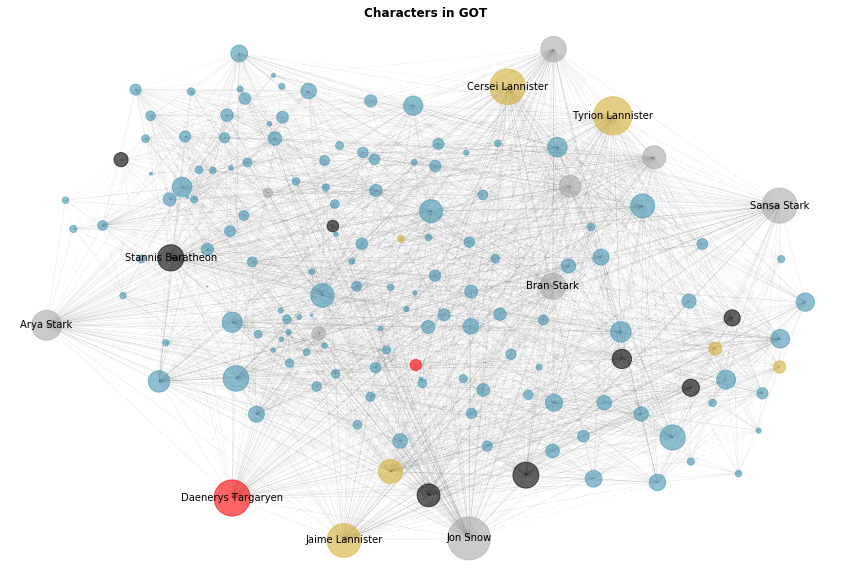

In [34]:
# Label list
labeling={}

for node in G.nodes:
    if G.degree(weight="weight")[node] > 1500:
        labeling[node] = node
        
# Node size list     
nodeSize = [G.degree(weight="weight")[character] for character in G.nodes] 

# Color list
colorList = [G.node[ch]["Color"] for ch in G.nodes]

# Plot a network graph
plt.figure(figsize=(15,10))
plt.axis("off")
nx.draw_networkx_edges(G, positions, width = 0.1, alpha = 0.25, arrows=False)
nx.draw_networkx_nodes(G, positions,alpha= 0.6, node_color = colorList,
                       node_size=[size/sum(nodeSize) * 100000/3 for size in nodeSize])
nx.draw_networkx_labels(G, positions, labels=labeling, font_size=10)
plt.title("Characters in GOT", fontweight='bold')
plt.savefig('Characters_nx.png')
plt.show()

Some helper functions to aid us in giving out awards.

In [35]:
# get color list --> different colors for top 3 characters

def getColorList(champion, first_runner_up, second_runner_up):
    colorList=[]
    for node in G.nodes:
        if node == champion:
            colorList.append("#ffd700") # gold
        elif node == first_runner_up:
            colorList.append("#aaa9ad") # silver
        elif node == second_runner_up:
            colorList.append("#cd7f32") # bronze
        else:
            colorList.append("#4495b3") # blue
    return colorList

In [36]:
# get label list --> label for top N charaters

def getLabeling(sortedList, topN):
    labeling={}
    for node in G.nodes:
        if node in list(map(lambda x : x[0], sortedList[:topN])):
            labeling[node] = node
    return labeling

In [44]:
# general plot function

def plot(sizes,colors, labeling, adjustFactor): # adjustFactor to control node size
    plt.figure(figsize=(15,10))
    plt.axis("off")
    nx.draw_networkx_edges(G, positions, width = 0.1, alpha = 0.25, arrows=False)
    nx.draw_networkx_nodes(G, positions,alpha= 0.7, node_color=colors,
                           node_size=[size * adjustFactor for size in sizes])
    nx.draw_networkx_labels(G, positions, labels=labeling, font_size=10)
    plt.savefig('Most_Reachable.png')
    plt.show()
    return 

### 2.1.1. Most Mentioned Award
Whose name is mentioned the most number of times in other characters' biographies?

In [38]:
sorting=sorted(list(G.in_degree(weight="weight")), key=lambda x : x[1], reverse=True)
top3=sorting[:3]
top3

[('Jon Snow', 2881), ('Daenerys Targaryen', 2030), ('Tyrion Lannister', 1990)]

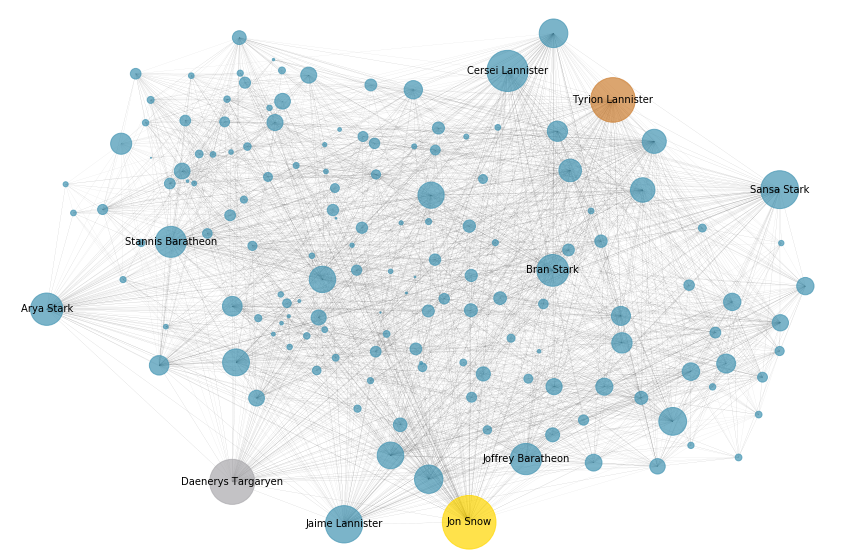

In [40]:
plot([G.in_degree(weight="weight")[character] for character in G.nodes],
     getColorList('Jon Snow','Daenerys Targaryen','Tyrion Lannister'),
     getLabeling(sorting, 10),1)

> ### <font color="#4482ad">The Most Mentioned Award goes to........Jon Snow!</font>

### 2.1.2. Most Social Award
Whose biography mentions the most number of other characters?

In [42]:
sorting=sorted(list(G.out_degree(weight="weight")), key=lambda x : x[1], reverse=True)
top3=sorting[:3]
top3

[('Sansa Stark', 1270), ('Tyrion Lannister', 1243), ('Jon Snow', 1183)]

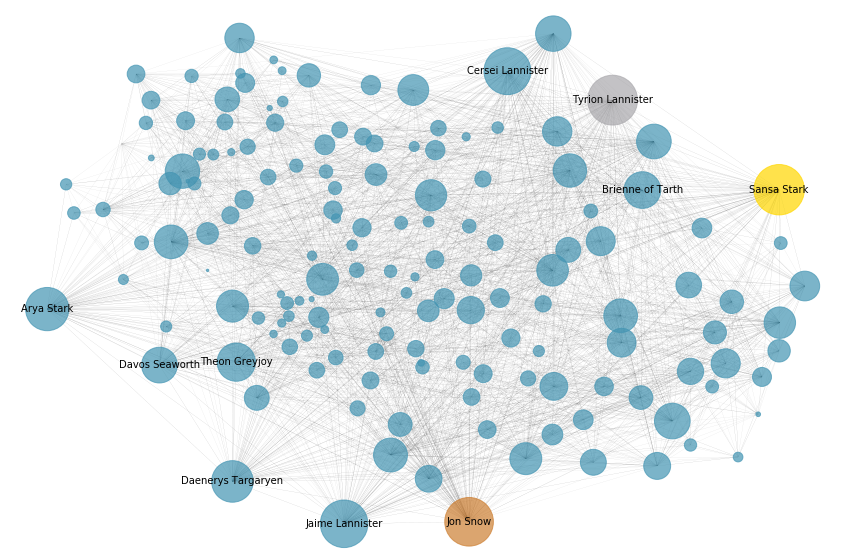

In [43]:
plot([G.out_degree(weight="weight")[character] for character in G.nodes],
     getColorList('Sansa Stark','Tyrion Lannister', 'Jon Snow'),
     getLabeling(sorting, 10), 2)

> ### <font color="#4482ad">The Most Social Award goes to........Sansa Stark!</font>

### 2.1.3. Most Reachable Award
Which node, on average, has the shortest distance for other nodes to reach it?

In [45]:
sorting=sorted(list(nx.closeness_centrality(G).items()), key=lambda x : x[1], reverse=True)
top3=sorting[:3]
top3

[('Jon Snow', 0.7677095631641087),
 ('Tyrion Lannister', 0.6909386068476978),
 ('Cersei Lannister', 0.6816434686389844)]

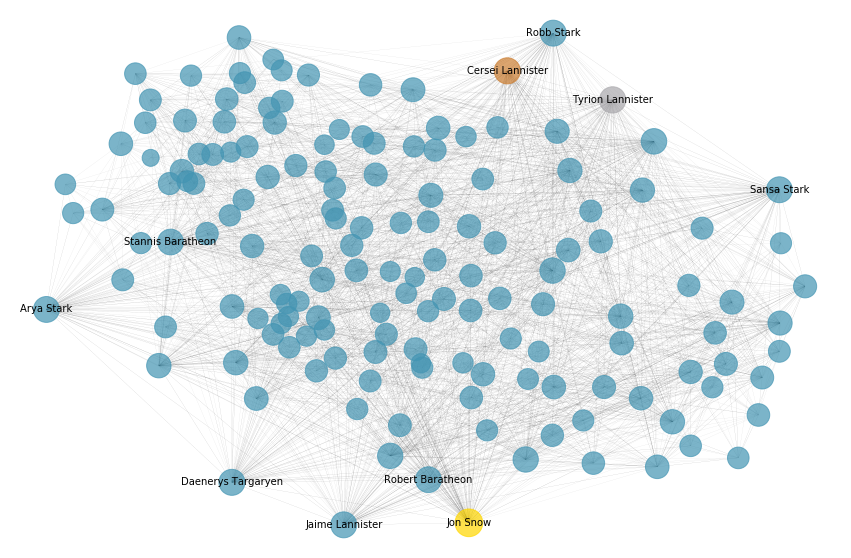

In [46]:
plot(list(nx.closeness_centrality(G).values()),
     getColorList('Jon Snow','Tyrion Lannister','Cersei Lannister'),
     getLabeling(sorting, 10), 1000)

> ### <font color="#4482ad">The Most Reachable Award goes to........Jon Snow!</font>

### 2.1.4 The Delivery-Man Award
Who is on average closest to other characters, starting from the node to other nodes? 
<br>
i.e. If a pizza is to be delivered to every character. One character is chosen to be the starting point. Who will be the chosen character such that the time taken to diliver pizzas is minimized?

In [47]:
sorting=sorted(list(nx.closeness_centrality(G.reverse()).items()), key=lambda x : x[1], reverse=True)
top3=sorting[:3]
top3

[('Jon Snow', 0.6609073745637623),
 ('Tyrion Lannister', 0.627723740694452),
 ('Jaime Lannister', 0.6225144150455354)]

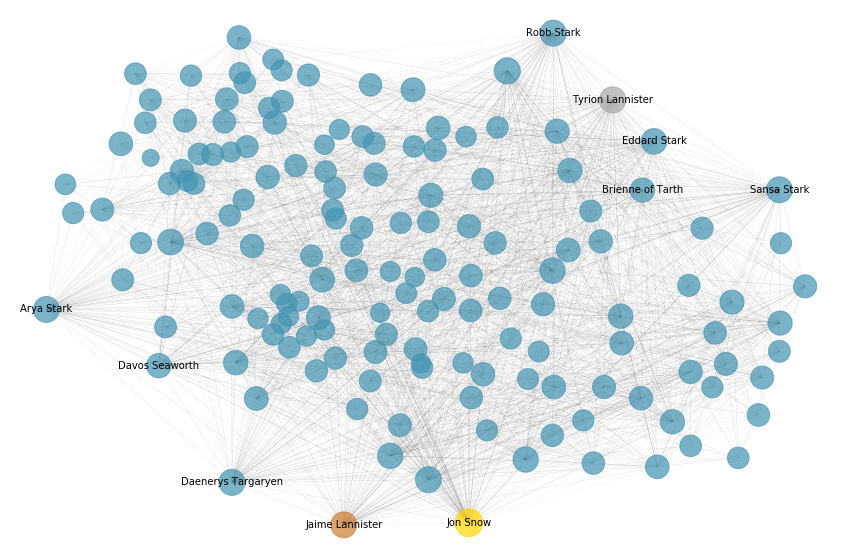

In [48]:
plot(list(nx.closeness_centrality(G).values()),
     getColorList('Jon Snow','Tyrion Lannister','Jaime Lannister'),
     getLabeling(sorting, 10), 1000)

> ### <font color="#4482ad">The Delivery-Man award goes to........Jon Snow!</font>

### 2.1.5 Most Critical Award 
Who is the Mr/Ms Important who appears the most number of times in the shortest path between any other two nodes?

In [49]:
sorting=sorted(list(nx.betweenness_centrality(G.reverse()).items()), key=lambda x : x[1], reverse=True)
top3=sorting[:3]
top3

[('Jon Snow', 0.10258812592928719),
 ('Daenerys Targaryen', 0.08495488238473345),
 ('Arya Stark', 0.07439741540442442)]

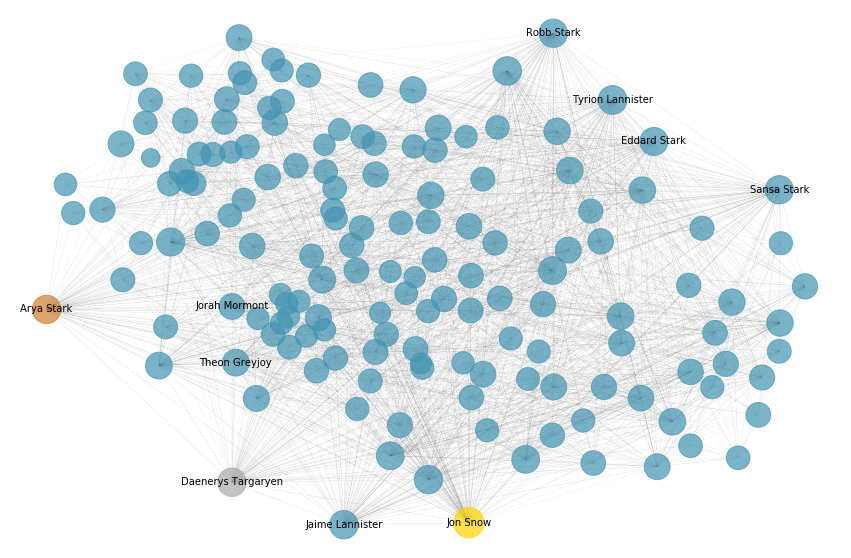

In [50]:
plot(list(nx.closeness_centrality(G).values()),
     getColorList('Jon Snow','Daenerys Targaryen','Arya Stark'),
     getLabeling(sorting, 10), 1200)

> ### <font color="#4482ad">The Most Critical Award goes to........Jon Snow!</font>

### 2.1.6 Networking Ninja Award
Who has the most powerful people as his connections? i.e. good if friends, bad if enemies!

In [85]:
sorting=sorted(list(nx.eigenvector_centrality(G).items()), key=lambda x : x[1], reverse=True)
top3=sorting[:3]
top3

[('Jon Snow', 0.20908603915428334),
 ('Cersei Lannister', 0.19097230878131516),
 ('Tyrion Lannister', 0.19014705946358837)]

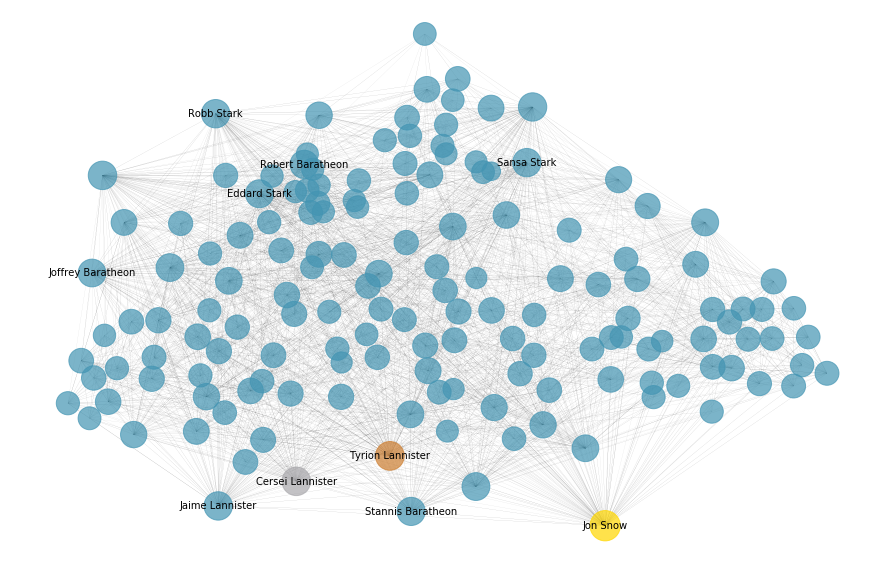

In [86]:
plot(list(nx.closeness_centrality(G).values()),
     getColorList('Jon Snow','Cersei Lannister','Tyrion Lannister'),
     getLabeling(sorting, 10), 1200)

> ### <font color="#4482ad"> The Networking Ninja Award goes to........Jon Snow!</font>

## 2.2. Build Networks of Noble Houses
* **Node**: name of the house
* **Edge**: if two houses have fought together/against each other; edge weight is the number of times they have been involved in the same battle

In [51]:
# define a function to build the house network

def House_Network(NodeList, EdgeDictionary):
    G=nx.Graph()
    G.add_nodes_from(NodeList)
    G.add_edges_from([(k[0], k[1], {"weight": v})for k,v in EdgeDictionary.items()])
    return G

### 2.2.1. Enemies and Allies

#### Network of Allies

In [52]:
# build a network of allies
ally_network=House_Network(houses, ally)

In [53]:
# use positions from the forceatlas algorithm for better visualization of graphs
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=0,

                        # Performance
                        jitterTolerance=0.0001,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=0.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.001,
                        strongGravityMode=False,
                        gravity=0,

                        # Log
                        verbose=False)

positions_ally = forceatlas2.forceatlas2_networkx_layout(ally_network, 
                                                    pos=None,iterations=1000)

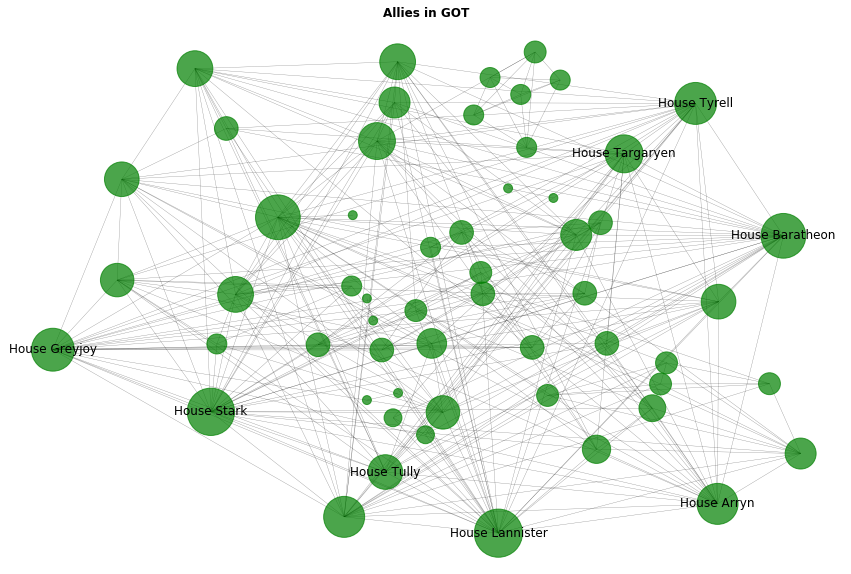

In [55]:
# Plot a network graph
labeling={}

for node in ally_network.nodes:
    if ally_network.degree(weight="weight")[node] > 30:
        labeling[node] = node

plt.figure(figsize=(15,10))
plt.axis("off")
nx.draw_networkx_edges(ally_network, positions_ally, width = 0.3, alpha = 0.5, arrows=False)
nx.draw_networkx_nodes(ally_network, positions_ally, alpha= 0.7, 
                       node_size=[ally_network.degree[n] * 80 for n in ally_network.nodes], node_color = "green")
nx.draw_networkx_labels(ally_network, positions_ally, labels=labeling)
plt.title("Allies in GOT", fontweight='bold')
plt.savefig('Ally_nx.png')
plt.show()

In [31]:
# Top N houses that fight together against common enemies most frequently
sorted([[node, ally_network.degree(weight = "weight")[node]] for node in ally_network],
      key=lambda x : x[1], reverse=True)[:5]

[['House Stark', 71],
 ['House Lannister', 61],
 ['House Baratheon', 57],
 ['House Tyrell', 47],
 ['House Targaryen', 46]]

In [32]:
# Top N houses that have the most number of allies
sorted([[node, ally_network.degree[node]] for node in ally_network],
      key=lambda x : x[1], reverse=True)[:5]

[['House Lannister', 29],
 ['House Stark', 28],
 ['House Bolton', 25],
 ['House Baratheon', 25],
 ['House Greyjoy', 23]]

#### Network of Enemies

In [60]:
# build a network of enemies
enemy_network=House_Network(houses, enemy)

In [61]:
# use positions from the forceatlas algorithm for better visualization of graphs
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=0,

                        # Performance
                        jitterTolerance=0.0001,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=0.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.001,
                        strongGravityMode=False,
                        gravity=0,

                        # Log
                        verbose=False)

positions_enemy = forceatlas2.forceatlas2_networkx_layout(enemy_network, 
                                                    pos=None,iterations=1000)

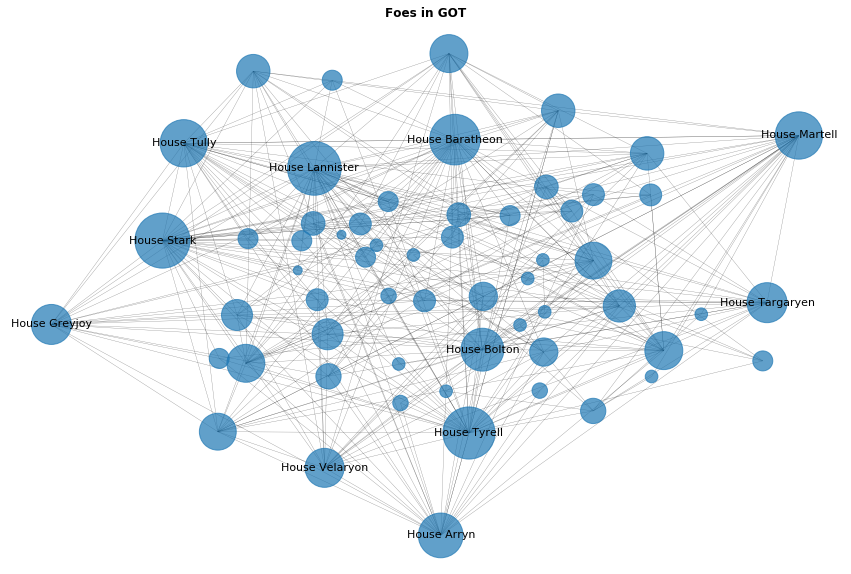

In [63]:
# Plot a network graph
labeling={}

for node in enemy_network.nodes:
    if enemy_network.degree(weight="weight")[node] > 25:
        labeling[node] = node

plt.figure(figsize=(15,10))
plt.axis("off")
nx.draw_networkx_edges(enemy_network, positions_enemy, width = 0.3, alpha = 0.5, arrows=False)
nx.draw_networkx_nodes(enemy_network, positions_enemy, alpha= 0.7, 
                       node_size=[enemy_network.degree[n] * 80 for n in enemy_network.nodes])
nx.draw_networkx_labels(enemy_network, positions_enemy, labels=labeling, font_size=11)
plt.title("Foes in GOT", fontweight='bold')
plt.savefig('Foes_nx.png')
plt.show()

In [64]:
# Top N houses that fight against each other most frequently
sorted([[node, enemy_network.degree(weight = "weight")[node]] for node in enemy_network],
      key=lambda x : x[1], reverse=True)[:5]

[['House Lannister', 67],
 ['House Stark', 64],
 ['House Tyrell', 58],
 ['House Baratheon', 51],
 ['House Martell', 46]]

In [65]:
# Top N houses that have the most number of enemies
sorted([[node, enemy_network.degree[node]] for node in enemy_network],
      key=lambda x : x[1], reverse=True)[:5]

[['House Stark', 38],
 ['House Lannister', 36],
 ['House Tyrell', 34],
 ['House Baratheon', 32],
 ['House Martell', 28]]

### 2.2.2. Communities
Identify communities in allies and enemies networks

In [67]:
def community(graph, pos):
    
    colors=['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
        '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', 
        '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', 
        '#aaffc3', '#808000', '#ffd8b1']
    
    partition=community_louvain.best_partition(graph, weight = "weight", random_state = 13)
    modurality=community_louvain.modularity(partition, graph, weight='weight')
    print("modurality is {}".format(modurality))
    print("********************************************************")
    partition_values = list(partition.values())
    partition_keys = list(partition.keys())
    partition_items = list(partition.items())
    
    community_dic={}
    for house,com in partition_items:
        if com in community_dic:
            community_dic[com] += [house,]
        else:
            community_dic[com] = [house,]

    js=json.dumps(community_dic, indent=2, sort_keys=True)
    print("********************************************************")
    plt.figure(figsize=(12,8))
    plt.axis("off")

    count = 0
    for com in set(partition_values):
        list_nodes = [partition_keys[i] for i in range(len(partition_keys)) if partition_values[i] == com]
        nx.draw_networkx_nodes(graph, pos, nodelist=list_nodes, node_size = 80, 
                               node_color = colors[count], node_shape='o')
        count = count + 1

    nx.draw_networkx_edges(graph,pos, list(graph.edges), 
                           width=0.15, arrows=False, 
                           alpha=0.9, edge_color="dimgray")

    plt.show()
    return js    

#### Community Network of Allies

modurality is 0.27157177124100484
********************************************************
********************************************************


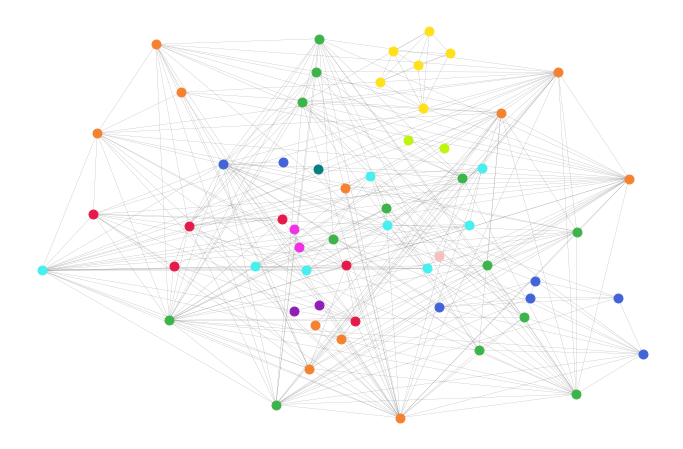

In [70]:
ally_js=community(ally_network,positions_ally)

In [71]:
print(ally_js)

{
  "0": [
    "House Glover",
    "House Florent",
    "House Karstark",
    "House Umber",
    "House Mormont",
    "House Reed"
  ],
  "1": [
    "House Gardener",
    "House Martell",
    "House Arryn",
    "House Durrandon",
    "House Greyiron",
    "House Mazin",
    "Night's Watch",
    "House Mudd",
    "Brotherhood Without Banners",
    "Free Folk",
    "House Hornwood",
    "House Royce",
    "House Stark"
  ],
  "2": [
    "House Dayne",
    "House Yronwood",
    "House Uller",
    "House Blackmont",
    "House Manwoody",
    "House Jordayne"
  ],
  "3": [
    "House Amber",
    "House Greenwood",
    "House Whitehill",
    "House Bolton",
    "House Frost",
    "House Hoare",
    "House Towers"
  ],
  "4": [
    "House Targaryen",
    "House Tarly",
    "House Velaryon",
    "House Frey",
    "House Tully",
    "House Lannister",
    "House Tyrell",
    "House Baratheon",
    "House Redwyne",
    "House Qoherys",
    "House Hightower"
  ],
  "5": [
    "House Forrester",
 

In [84]:
ally_dic=json.loads(ally_js)
df_res = pd.DataFrame()
for i in range(len(ally_dic)):
    df_new = pd.DataFrame({'Community ' + str(i) : ally_dic[str(i)]})
    df_res = pd.concat([df_res,df_new], ignore_index=True, axis=1)

0                            1                2   \
0     House Glover               House Gardener      House Dayne   
1    House Florent                House Martell   House Yronwood   
2   House Karstark                  House Arryn      House Uller   
3      House Umber              House Durrandon  House Blackmont   
4    House Mormont               House Greyiron   House Manwoody   
5       House Reed                  House Mazin   House Jordayne   
6              NaN                Night's Watch              NaN   
7              NaN                   House Mudd              NaN   
8              NaN  Brotherhood Without Banners              NaN   
9              NaN                    Free Folk              NaN   
10             NaN               House Hornwood              NaN   
11             NaN                  House Royce              NaN   
12             NaN                  House Stark              NaN   

                 3                4                5                  6   \
0       House Amber  House Targaryen  House Forrester       House Botley   
1   House Greenwood      House Tarly   House Glenmore      House Greyjoy   
2   House Whitehill   House Velaryon              NaN       House Merlyn   
3      House Bolton       House Frey              NaN        House Sparr   
4       House Frost      House Tully              NaN    House Blacktyde   
5       House Hoare  House Lannister              NaN       House Harlaw   
6      House Towers     House Tyrell              NaN        House Drumm   
7               NaN  House Baratheon              NaN  House Goodbrother   
8               NaN    House Redwyne              NaN                NaN   
9               NaN    House Qoherys              NaN                NaN   
10              NaN  House Hightower              NaN                NaN   
11              NaN              NaN              NaN                NaN   
12              NaN              NaN              NaN                NaN   

               7              8                9              10  
0   House Tarbeck  House Darklyn  House Blackfyre  White Walkers  
1     House Reyne  House Hollard              NaN            NaN  
2             NaN            NaN              NaN            NaN  
3             NaN            NaN              NaN            NaN  
4             NaN            NaN              NaN            NaN  
5             NaN            NaN              NaN            NaN  
6             NaN            NaN              NaN            NaN  
7             NaN            NaN              NaN            NaN  
8             NaN            NaN              NaN            NaN  
9             NaN            NaN              NaN            NaN  
10            NaN            NaN              NaN            NaN  
11            NaN            NaN              NaN            NaN  
12            NaN            NaN              NaN            NaN

In [85]:
df_res.to_excel("ally_community.xlsx")

#### Community Network of Enemies

modurality is 0.18886009095799308
********************************************************
********************************************************


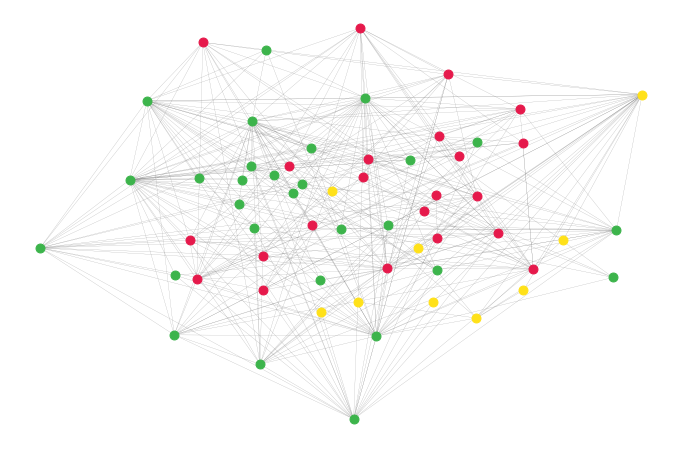

In [68]:
enemy_js=community(enemy_network, positions_enemy)

In [69]:
print(enemy_js)

{
  "0": [
    "House Glover",
    "House Amber",
    "House Forrester",
    "House Greenwood",
    "House Florent",
    "House Glenmore",
    "House Karstark",
    "House Mazin",
    "House Whitehill",
    "Night's Watch",
    "Brotherhood Without Banners",
    "Free Folk",
    "House Hornwood",
    "House Umber",
    "House Mormont",
    "House Royce",
    "House Bolton",
    "House Reed",
    "White Walkers",
    "House Frost",
    "House Hoare",
    "House Towers"
  ],
  "1": [
    "House Gardener",
    "House Targaryen",
    "House Tarly",
    "House Botley",
    "House Tarbeck",
    "House Arryn",
    "House Greyjoy",
    "House Merlyn",
    "House Durrandon",
    "House Velaryon",
    "House Frey",
    "House Sparr",
    "House Blacktyde",
    "House Darklyn",
    "House Tully",
    "House Lannister",
    "House Tyrell",
    "House Harlaw",
    "House Blackfyre",
    "House Reyne",
    "House Stark",
    "House Baratheon",
    "House Redwyne",
    "House Drumm",
    "House Qoher

In [93]:
enemy_dic=json.loads(enemy_js)
df_enemy = pd.DataFrame()
for i in range(len(enemy_dic)):
    df_new = pd.DataFrame({'Community ' + str(i) : enemy_dic[str(i)]})
    df_enemy = pd.concat([df_enemy,df_new], ignore_index=True, axis=1)

In [94]:
df_enemy

0                  1                2
0                  House Glover     House Gardener    House Martell
1                   House Amber    House Targaryen      House Dayne
2               House Forrester        House Tarly   House Yronwood
3               House Greenwood       House Botley      House Uller
4                 House Florent      House Tarbeck  House Blackmont
5                House Glenmore        House Arryn   House Greyiron
6                House Karstark      House Greyjoy   House Manwoody
7                   House Mazin       House Merlyn       House Mudd
8               House Whitehill    House Durrandon   House Jordayne
9                 Night's Watch     House Velaryon              NaN
10  Brotherhood Without Banners         House Frey              NaN
11                    Free Folk        House Sparr              NaN
12               House Hornwood    House Blacktyde              NaN
13                  House Umber      House Darklyn              NaN
14                House Mormont        House Tully              NaN
15                  House Royce    House Lannister              NaN
16                 House Bolton       House Tyrell              NaN
17                   House Reed       House Harlaw              NaN
18                White Walkers    House Blackfyre              NaN
19                  House Frost        House Reyne              NaN
20                  House Hoare        House Stark              NaN
21                 House Towers    House Baratheon              NaN
22                          NaN      House Redwyne              NaN
23                          NaN        House Drumm              NaN
24                          NaN      House Qoherys              NaN
25                          NaN    House Hightower              NaN
26                          NaN  House Goodbrother              NaN
27                          NaN      House Hollard              NaN

In [95]:
df_enemy.to_excel("enemy_community.xlsx")

# 3. Natural Language Processing

## 3.1. Word Cloud
generate a word cloud based on a character's script

In [96]:
# define a function to get all names/aliases of a character

def getNames():
    lst=[]
    for (k,v) in characters.items():
        lst.append(k.lower())
        lst.extend([vi.lower() for vi in v])
    return lst
nameList=getNames()

In [97]:
# helper functions for keyWords()

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
    
def extract_topn_from_vector(feature_names, sorted_items, topn):
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a dictionary of feature,score
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [98]:
# define a function to get the top N most frequent keywords using tf-idf

def keyWords(character, topN, excludeNames=False):
    page=pages[character].lower()
    
    if excludeNames:
        for name in nameList:
            page = page.replace(name, "")
    
    sentences=page.split(".")
    
    # init a count vector
    count_vector=CountVectorizer(max_df=0.9,stop_words="english")

    # create a word count for sentences
    word_count_vector=count_vector.fit_transform(sentences)
    
    # init a tfidf transformer
    tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
    
    # fit with the word count vector
    tfidf_transformer.fit(word_count_vector)
    
    # sub our interested doc into the transformer
    tf_idf_vector=tfidf_transformer.transform(count_vector.transform([page]))
    
    # get the key words
    feature_names=count_vector.get_feature_names()
    sorted_items=sort_coo(tf_idf_vector.tocoo())
    keywords=extract_topn_from_vector(feature_names,sorted_items,topN)
    
    return keywords

In [99]:
keyWords('Cersei_Lannister', 3, True)

{'king': 0.2, 'tells': 0.169, 'children': 0.131}

In [108]:
# define a function to generate a word cloud for a character from the character's script
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
def wordCloud(character, mask_path = None, number_words=100, excludeName=False):
    if mask_path == None:
        pic_mask = np.array(Image.open("iron_throne.jpeg"))
    else:
        pic_mask = np.array(Image.open(mask_path))
    word_cloud = wordcloud.WordCloud(background_color="white", width=800, height=500, 
                        max_words = number_words, colormap = 'Blues',
                        mask=pic_mask)
    word_cloud.generate_from_frequencies(
        keyWords(character, number_words, excludeName))
    image_colors = ImageColorGenerator(pic_mask)
    
    plt.figure(figsize=(15,10))
    plt.title("{}'s WordCloud".format(character.replace("_", " ")), y=1.05)
    plt.imshow(word_cloud.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")
    plt.savefig('Daenerys_Targaryen_excludename.png')
    plt.show()
    return

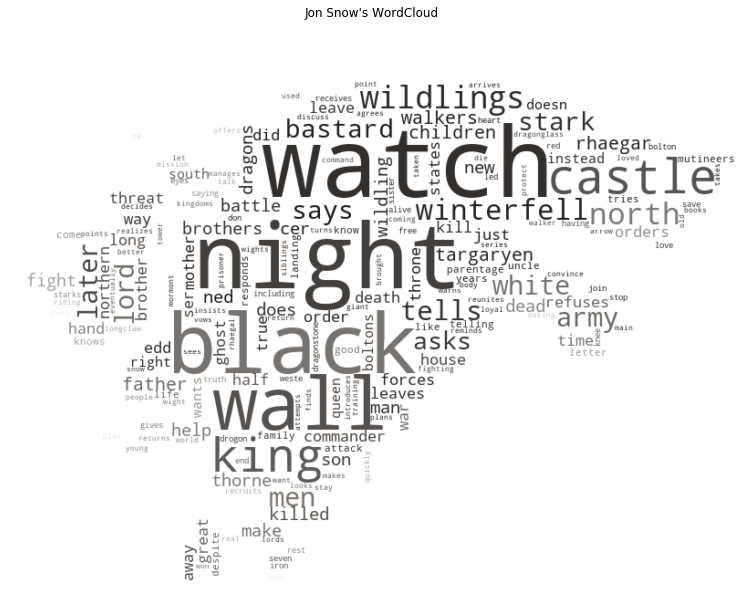

In [102]:
wordCloud("Jon_Snow", "Jon_Snow.jpg", number_words=200, excludeName=True)

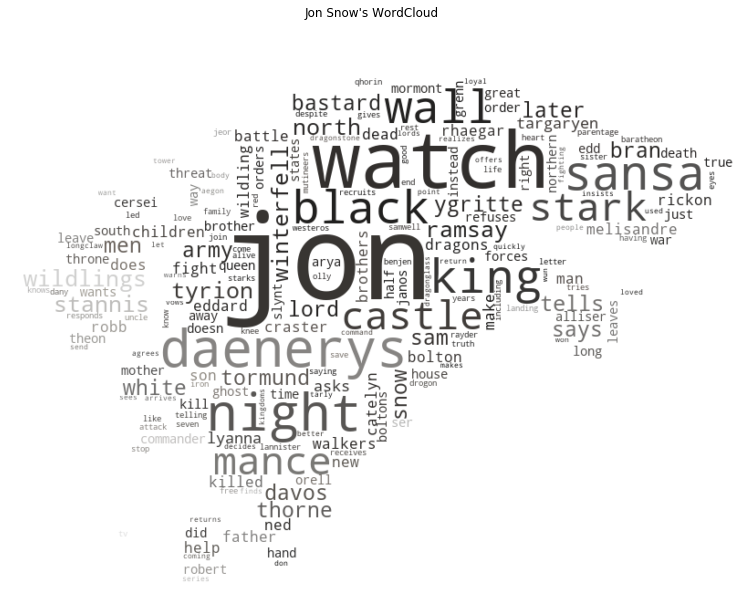

In [104]:
wordCloud("Jon_Snow", "Jon_Snow.jpg", number_words=200)

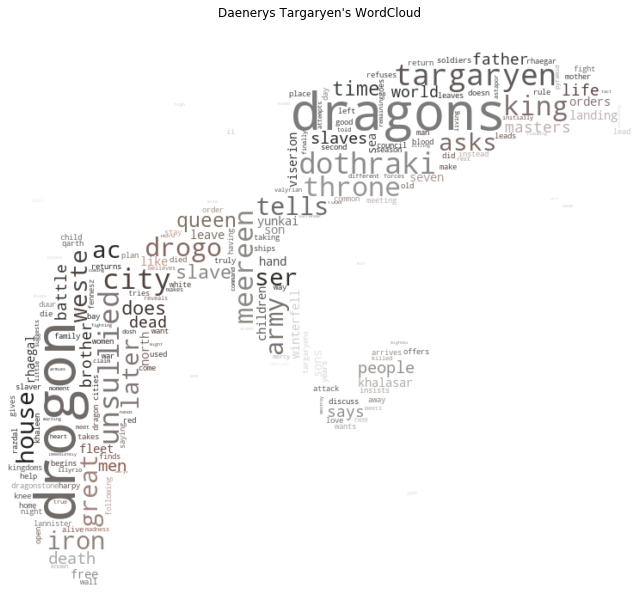

In [109]:
wordCloud("Daenerys_Targaryen", "Daenerys_Targaryen.jpg", number_words=200, excludeName=True)

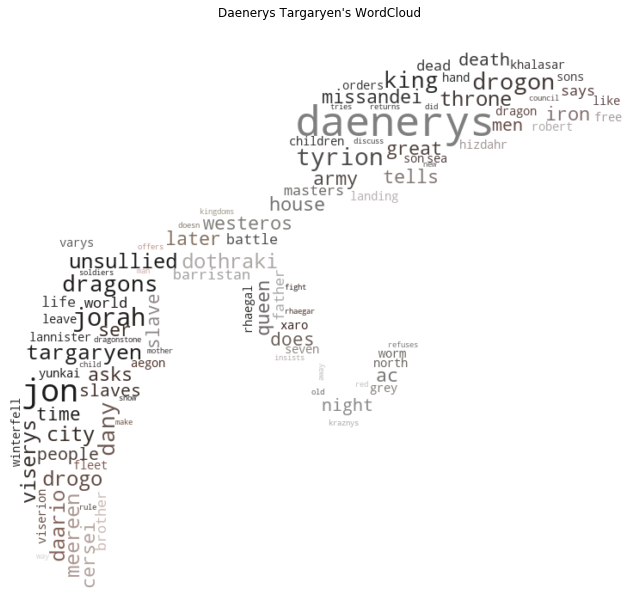

In [107]:
wordCloud("Daenerys_Targaryen", "Daenerys_Targaryen.jpg", number_words=100, excludeName=False)

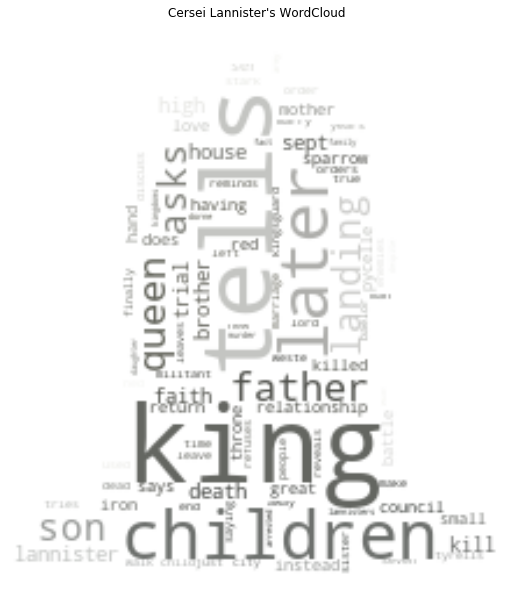

In [203]:
wordCloud("Cersei_Lannister", number_words=200, excludeName=True)

## Sentiment Analysis

<img src = "https://journals.plos.org/plosone/article/file?type=thumbnail&id=info:doi/10.1371/journal.pone.0026752.e006" style="float: left">

In [3]:
# read data
S1 = pd.read_csv('Data_Set_S1.txt', sep="\t", header=0)
S1.head()

word  happiness_rank  happiness_average  happiness_standard_deviation  \
0   laughter               1               8.50                        0.9313   
1  happiness               2               8.44                        0.9723   
2       love               3               8.42                        1.1082   
3      happy               4               8.30                        0.9949   
4    laughed               5               8.26                        1.1572   

  twitter_rank google_rank nyt_rank lyrics_rank  
0         3600          --       --        1728  
1         1853        2458       --        1230  
2           25         317      328          23  
3           65        1372     1313         375  
4         3334        3542       --        2332

In [4]:
# create a dictionary mapping word to its happiness_average value
word_happiness = dict(zip(S1.word.tolist(), S1.happiness_average.tolist()))

In [5]:
def sentiment(tokens):
    total=0
    count=0
    for t in tokens:
        # if the token t is found in the happiness list
        if t in word_happiness:
            total += word_happiness[t]
            count +=1
    # if no tokens are found in the happiness list
    if count == 0:
        return 0
    return total/count

In [6]:
def getTokens(name):
    script=scripts[name]
    if len(script) < 100: # filter out main characters
        return []
    lst=list(map(lambda x : word_tokenize(x), script))
    res=[x for sentence in lst for x in sentence]
    return res

### Who is the happiest person in GOT?

In [7]:
def happy():
    dic={}
    for name in characters:
        score=sentiment(getTokens(name))
        if score == 0:
            continue
        dic[name]=score
    return dic

In [31]:
happy_dic=happy()

In [32]:
sorted(happy_dic.items(), key=lambda x : x[1], reverse=True)[:3]

[('Margaery Tyrell', 5.535182291666641),
 ('Petyr Baelish', 5.488950354609997),
 ('Roose Bolton', 5.474170040485801)]

### Who is the least happy person in GOT?

In [33]:
sorted(happy_dic.items(), key=lambda x : x[1])[:3]

[('Grey Worm', 5.285888538380629),
 ('Qyburn', 5.292692307692287),
 ('Barristan Selmy', 5.321741452991437)]